# Wavelets decomposition

- author Sylvie Dagoret-Campagne
- creation date August 14th 2020

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [48]:
import libatmscattering as atm

In [49]:
import pywt

In [50]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = 18

In [51]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

In [52]:
def thresh_hard_sparse(x, k):
    """
    Keep only k largest entries of x and return their indices.
    Parameters
    ----------
    x : numpy array
        Numpy array to be thresholded
    k : int
        Number of largest entries in absolute value to keep
    Notes
    """
    _x = x.copy()
    ind = np.argpartition(abs(_x), -k, axis=None)[-k:]
    ind = np.unravel_index(ind, _x.shape)
    ind_del = np.ones(_x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    return ind, _x

In [53]:
DATADIR="../../data/atm"

In [54]:
atmospheric_basename_files=os.listdir(DATADIR)

In [55]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [56]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [57]:
hdu = fits.open(input_file)

In [58]:
hdr=hdu[0].header
data=hdu[0].data

In [59]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [60]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [61]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [62]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]

In [63]:
NWL=wl.shape[0]

In [64]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [65]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

In [66]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [67]:
WLMINSEL=350.
WLMAXSEL=1100.

In [68]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [69]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [70]:
len(indexes_selected)

750

In [71]:
wl=wl[indexes_selected]
transm=transm[:,indexes_selected]

In [72]:
WLMIN=wl[0]
WLMAX=wl[-1]

In [73]:
#transm0=transm[0]*0.96
transm0=transm[0]

In [74]:
od=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od)

Text(0, 0.5, 'att (mag)')

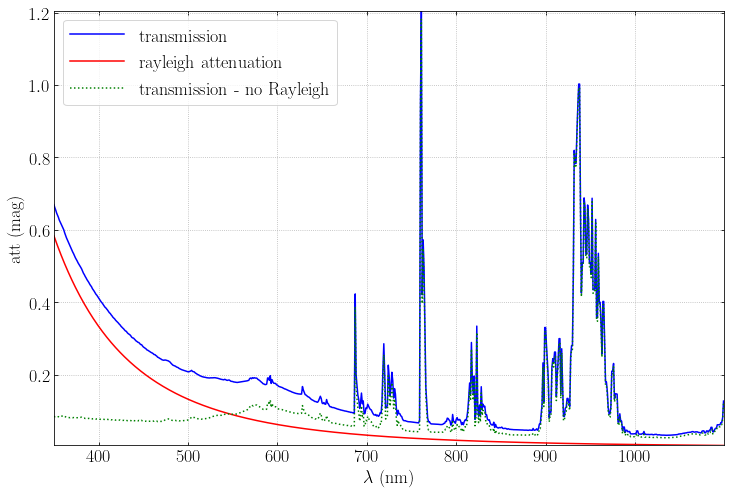

In [75]:
ax = plt.subplot(111)
ax.plot(wl,-2.5*np.log10(transm0),'b-',label="transmission")
ax.plot(wl,-2.5*np.log10(att_rayleigh),'r-',label="rayleigh attenuation")
ax.plot(wl,-2.5*np.log10(transm0/att_rayleigh),'g:',label="transmission - no Rayleigh")
ax.legend()
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("att (mag)")

# wavelet decomposition

In [76]:
# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)

In [77]:
wname = "db1"
w = pywt.Wavelet(wname)

In [78]:
maxlvl=pywt.dwt_max_level(data_len=len(h), filter_len=w.dec_len)

In [79]:
maxlvl

9

In [80]:
nlevels=8

In [81]:
coeffs = pywt.wavedec(h, w, level=nlevels)

In [90]:
len(coeffs)

9

In [83]:
full_rec=pywt.waverec(coeffs, w)

coeffs[8] = np.zeros_like(coeffs[8])
coeffs[7] = np.zeros_like(coeffs[7])

rec_1=pywt.waverec(coeffs, w)

coeffs[6] = np.zeros_like(coeffs[6])
coeffs[5] = np.zeros_like(coeffs[5])

rec_2=pywt.waverec(coeffs, w)

coeffs[4] = np.zeros_like(coeffs[4])
coeffs[3] = np.zeros_like(coeffs[3])

rec_3=pywt.waverec(coeffs, w)

coeffs[2] = np.zeros_like(coeffs[2])
coeffs[1] = np.zeros_like(coeffs[1])

rec_4=pywt.waverec(coeffs, w)


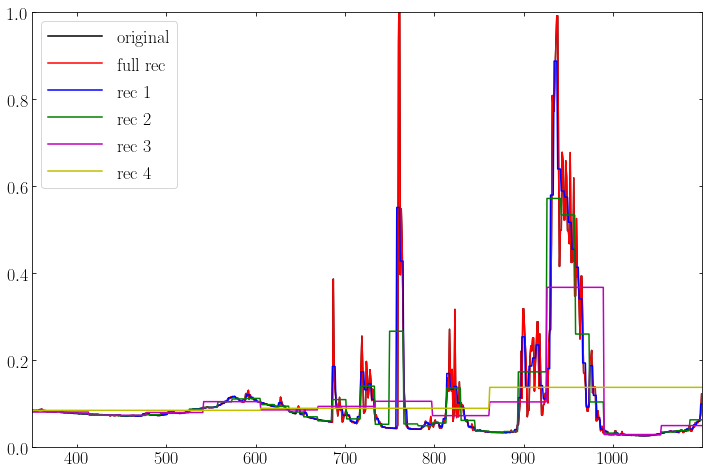

In [84]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111)

ax.plot(t,h,"k-",label="original")
ax.plot(t,full_rec,"r-",label="full rec")
ax.plot(t,rec_1,"b-",label="rec 1")
ax.plot(t,rec_2,"g-",label="rec 2")
ax.plot(t,rec_3,"m-",label="rec 3")
ax.plot(t,rec_4,"y-",label="rec 4")
ax.set_ylim(0,1)
ax.legend()

# Coefficients

In [85]:
w = pywt.Wavelet(wname)
coeffs = pywt.wavedec(h, w, level=nlevels)

In [86]:
coeffs_vec, coeffs_slices, coeffs_shapes = pywt.ravel_coeffs(coeffs)

In [87]:
# UTILISATION DES 100 premiers coeff
n_coeffs = 100
_, coeffs_k = thresh_hard_sparse(coeffs_vec, n_coeffs)
new_coeffs = pywt.unravel_coeffs(coeffs_k, coeffs_slices, coeffs_shapes)
rec_signal = pywt.waverecn(new_coeffs,wname, mode = "per")

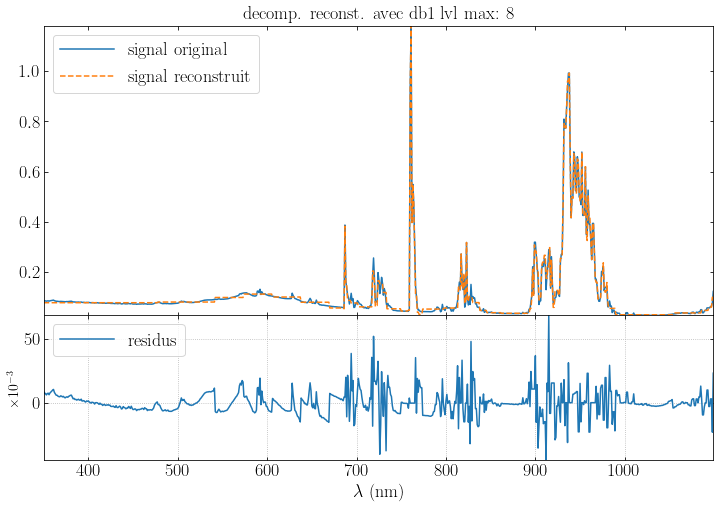

In [88]:
#plot

fig = plt.figure(figsize=(12,8))


gs = plt.GridSpec(2, 1, hspace=0, height_ratios=[1,1/2])



ax0 = fig.add_subplot(gs[0,:])
ax0.plot(t,h,label='signal original')
ax0.plot(t,rec_signal, label='signal reconstruit', linestyle='--')
ax0.legend(loc='upper left')
ax0.set_title('decomp. reconst. avec '+wname+' lvl max: '+str(nlevels))
ax0.set_xticklabels([])
#
#
ax1 = fig.add_subplot(gs[1,:])
ax1.plot(t,h-rec_signal,label='residus')
ax1.legend(loc='upper left')
ax1.ticklabel_format(axis='y',style='sci',scilimits=(-3,-3))
ax1.yaxis.get_offset_text().set_visible(False)
#ax1.set_ylim([-10**(-6),10**(-6)])
ax1.set_xlabel("$\lambda$ (nm)")
ax1.set_ylabel(r"$\times 10^{-3}$", fontsize=14)
ax1.grid()
plt.show()

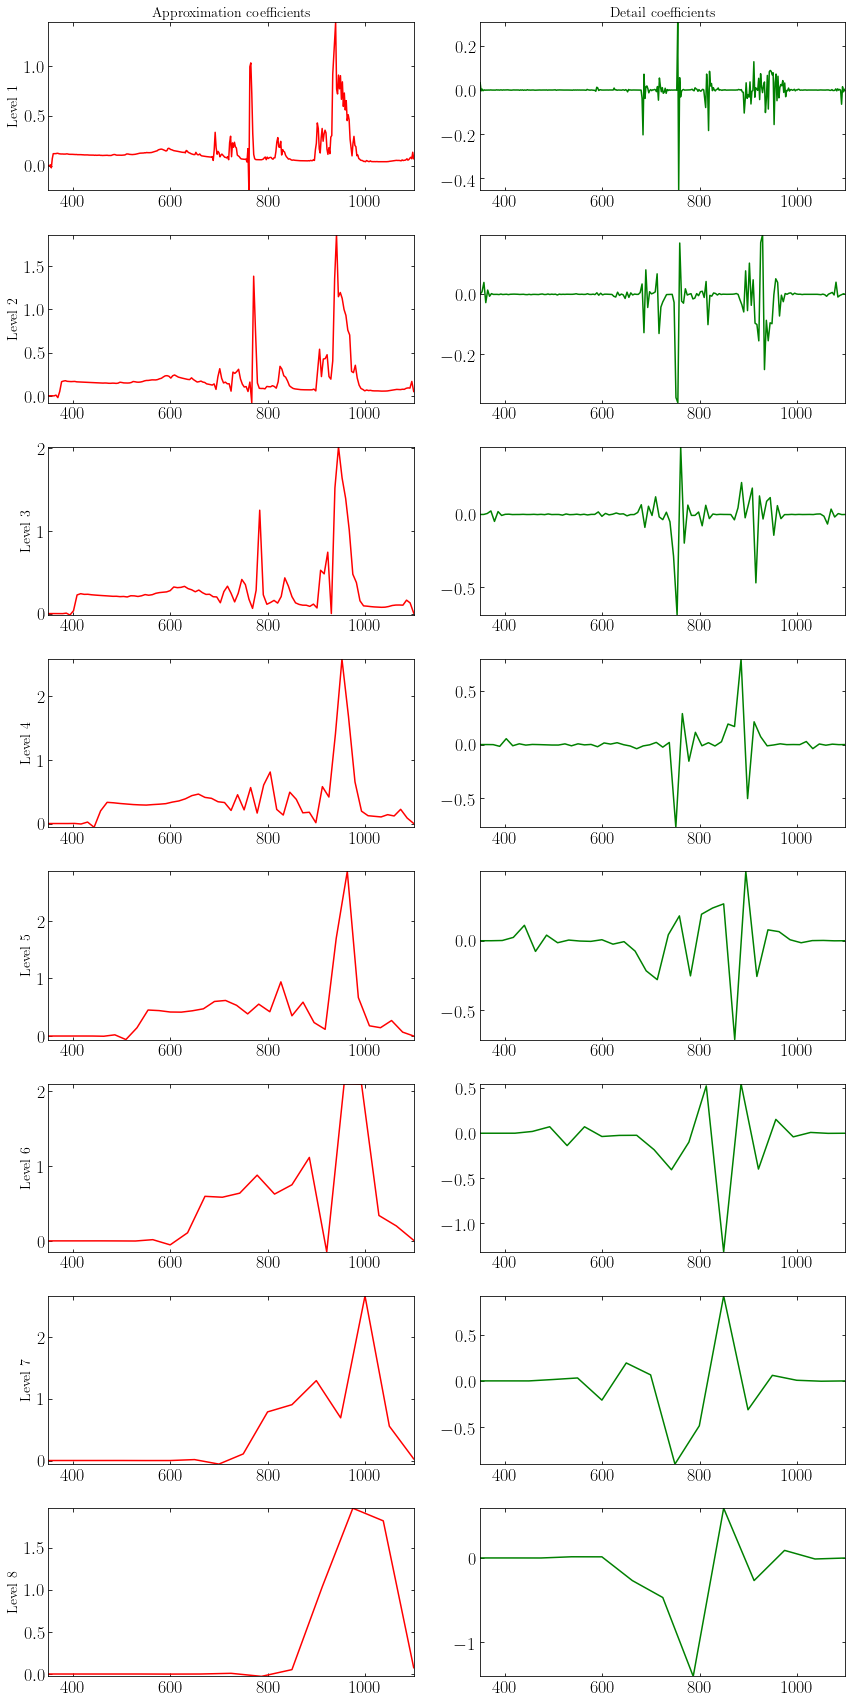

In [89]:
w = pywt.Wavelet(wname)
data = h

# number of levels
#maxlvl=pywt.dwt_max_level(data_len=len(data), filter_len=w.dec_len)

# limit to the number of levels chosen, here nlevels=6
maxlvl=nlevels

fig, axarr = plt.subplots(nrows=maxlvl, ncols=2, figsize=(12,3*maxlvl))

# loop on levels
for ii in range(maxlvl):
    (data, coeff_d) = pywt.dwt(data, 'db6', mode='zero')
    
    X=np.linspace(WLMIN,WLMAX,len(data))
    
    axarr[ii, 0].plot(X,data, 'r')
    axarr[ii, 1].plot(X,coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
#    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
#    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show() 